In [1]:
import keras
from keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
import tensorflow as tf

In [2]:
# @title Activate GPU
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Data

In [3]:
# @title data for simple CV
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 784)
(10000, 784)


In [2]:
# @title data with channels

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))
x_train.shape,x_test.shape

11490434/11490434 [==============================] - 0s 0us/step


((60000, 28, 28, 1), (10000, 28, 28, 1))

In [62]:
# @title Simple auto-encoder
# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

## **Compressing autoencoders**

In [6]:
# @title Deep auto-encoder
input_img = keras.Input(shape=(784,))
encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)

encoded = layers.Dense(32, activation='relu')(encoded)

decoded = layers.Dense(64, activation='relu')(encoded)
decoded = layers.Dense(128, activation='relu')(decoded)
decoded = layers.Dense(784, activation='sigmoid')(decoded)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

In [66]:
# @title Convolutional autoencoder
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_74"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 8)           0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 8)           584

In [55]:
# @title slicing autoencoder models
def get_encoder(original_model, output_layer_name):
  # Get layer by name (no need for set_weights() here)
  output_layer = original_model.get_layer(output_layer_name).output

  # Get weights from the original model for layers up to the output layer
  # This line retrieves a list of weight tensors for all layers in the path
  layer_weights = []
  for layer in original_model.layers:
    if layer.name == output_layer_name:
      break  # Stop iterating once we reach the desired layer
    layer_weights.append(layer.get_weights())

  # Create a new model with layers up to the specified output layer
  partial_model = keras.Model(inputs=original_model.inputs, outputs=output_layer)

  # Set the weights in the partial model (for layers included in the model)
  for i, layer in enumerate(partial_model.layers):
    if i < len(layer_weights):  # Only set weights for included layers
      layer.set_weights(layer_weights[i])

  return partial_model
def get_decoder(original_model, start_layer_name):
  # Get the starting layer by name
  start_layer = original_model.get_layer(start_layer_name)

  # Find the index of the starting layer
  start_index = original_model.layers.index(start_layer)

  # Get layer weights from the starting layer to the end
  layer_weights = []
  for layer in original_model.layers[start_index+1:]:  # Use start_index here
    layer_weights.append(layer.get_weights())

  # Create a new model with layers from the starting layer to the end
  # Exclude the input layer when creating the partial model

  partial_model = keras.Model(inputs=start_layer.output, outputs=original_model.outputs)

  # Set the weights in the partial model, starting from the first layer with weights
  for i, layer in enumerate(partial_model.layers[1:]): # Start from index 1 to skip the input layer
    layer.set_weights(layer_weights[i]) # Adjust index to match layer_weights

  return partial_model

Model: "model_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
Total params: 110816 (432.88 KB)
Trainable params: 110816 (432.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   


In [ ]:
# @title where to be sliced
# Example usage (assuming autoencoder is your original model)
encoder = get_encoder(autoencoder, "dense_8")
decoder = get_decoder(autoencoder, "dense_8")
encoder.summary()
decoder.summary()

In [ ]:
# @title Custom callbacks for accuracy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# ... rest of your code ...

# Define a callback to monitor loss and accuracy on both train and validation data
class TrainingMonitor(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    train_loss = logs['loss']
    # train_acc = logs['accuracy']  # Assuming your autoencoder uses accuracy metric
    # val_loss = logs['val_loss']
    # val_acc = logs['val_accuracy']  # Assuming your autoencoder uses accuracy metric
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}')#, Train Accuracy: {train_acc:.4f}', Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

# Create an instance of the callback
monitor = TrainingMonitor()

# **Denoising autoencoders**

11490434/11490434 [==============================] - 0s 0us/step


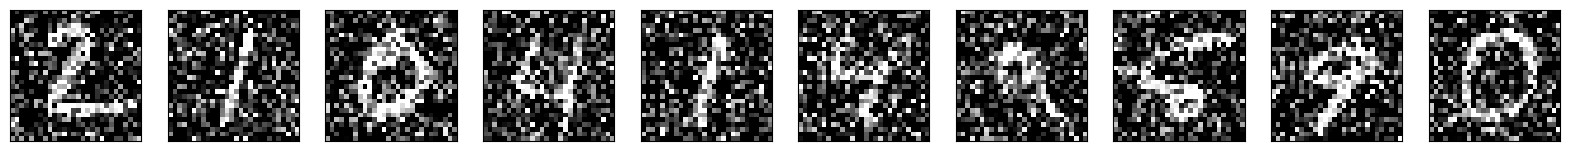

In [3]:
# @title Add gaussian noisy to data


(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [4]:
# @title Denoising autoencoder architecture
input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# At this point the representation is (7, 7, 32)

x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# **Variational Autoencoder**

In [4]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

#building model

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')


reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 784)]                0         []                            
                                                                                                  
 encoder (Functional)        [(None, 2),                  50500     ['input_1[0][0]']             
                              (None, 2),                                                          
                              (None, 2)]                                                          
                                                                                                  
 decoder (Functional)        (None, 784)                  51152     ['encoder[0][2]']             
                                                                                            

In [5]:
# @title Training VAE
batch_size = 32
vae.fit(x_train, x_train,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test))


Epoch 1/100
1875/1875 [==============================] - 36s 13ms/step - loss: 188.4668 - val_loss: 171.3151
Epoch 2/100
1875/1875 [==============================] - 11s 6ms/step - loss: 168.2498 - val_loss: 165.1549
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 163.6675 - val_loss: 161.8073
Epoch 4/100
1875/1875 [==============================] - 8s 4ms/step - loss: 161.0474 - val_loss: 160.1255
Epoch 5/100
1875/1875 [==============================] - 8s 4ms/step - loss: 159.3686 - val_loss: 158.6991
Epoch 6/100
1875/1875 [==============================] - 8s 4ms/step - loss: 158.0796 - val_loss: 157.8822
Epoch 7/100
1875/1875 [==============================] - 7s 4ms/step - loss: 157.0896 - val_loss: 157.0318
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 156.2884 - val_loss: 156.3135
Epoch 9/100
1875/1875 [==============================] - 8s 4ms/step - loss: 155.6463 - val_loss: 155.5462
Epoch 10/100
1875/1875 [==========

In [6]:
# @title Training denoising autoencoder
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/100
469/469 [==============================] - 15s 11ms/step - loss: 0.1690 - val_loss: 0.1197
Epoch 2/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1167 - val_loss: 0.1123
Epoch 3/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1110 - val_loss: 0.1081
Epoch 4/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1072 - val_loss: 0.1047
Epoch 5/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1047 - val_loss: 0.1027
Epoch 6/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1029 - val_loss: 0.1017
Epoch 7/100
469/469 [==============================] - 3s 6ms/step - loss: 0.1017 - val_loss: 0.1002
Epoch 8/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1007 - val_loss: 0.0997
Epoch 9/100
469/469 [==============================] - 3s 7ms/step - loss: 0.1000 - val_loss: 0.0987
Epoch 10/100
469/469 [==============================] - 3s 6ms/step - loss: 0.0994 - val_

In [10]:
# @title training rest of auto-encoder

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))#,
                #callbacks=[monitor])


Epoch 1/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0655 - val_loss: 0.0650
Epoch 2/50
235/235 [==============================] - 3s 11ms/step - loss: 0.0654 - val_loss: 0.0651
Epoch 3/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0653 - val_loss: 0.0649
Epoch 4/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0652 - val_loss: 0.0647
Epoch 5/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0651 - val_loss: 0.0646
Epoch 6/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0650 - val_loss: 0.0646
Epoch 7/50
235/235 [==============================] - 2s 11ms/step - loss: 0.0650 - val_loss: 0.0645
Epoch 8/50
235/235 [==============================] - 2s 10ms/step - loss: 0.0649 - val_loss: 0.0645
Epoch 9/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0649 - val_loss: 0.0644
Epoch 10/50
235/235 [==============================] - 2s 9ms/step - loss: 0.0648 - val_loss: 0

1/1 [==============================] - 0s 19ms/step


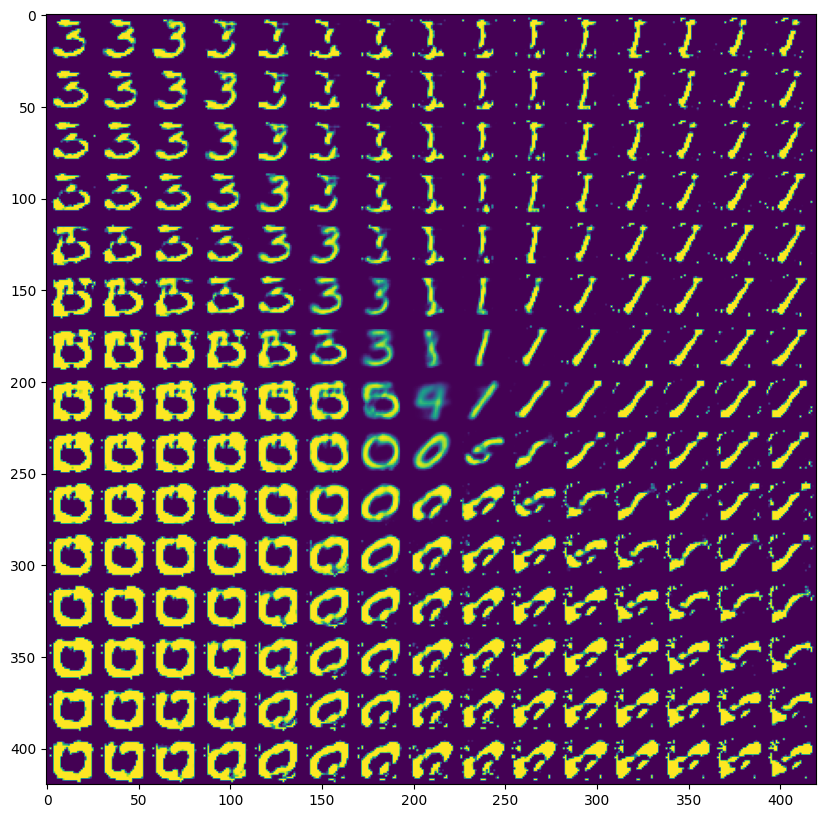

In [6]:
# @title Generating
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

313/313 [==============================] - 2s 3ms/step


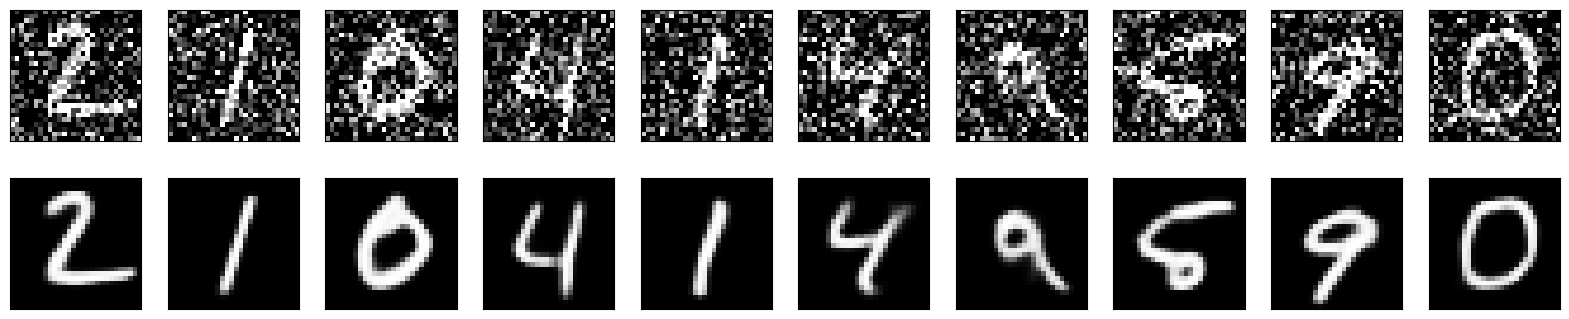

In [7]:
# @title Plotting resutls for denoiser
denoised = autoencoder.predict(x_test_noisy)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


    ax = plt.subplot(2, n, i+n)
    plt.imshow(denoised[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Result for compressing auto-encoder

313/313 [==============================] - 1s 3ms/step


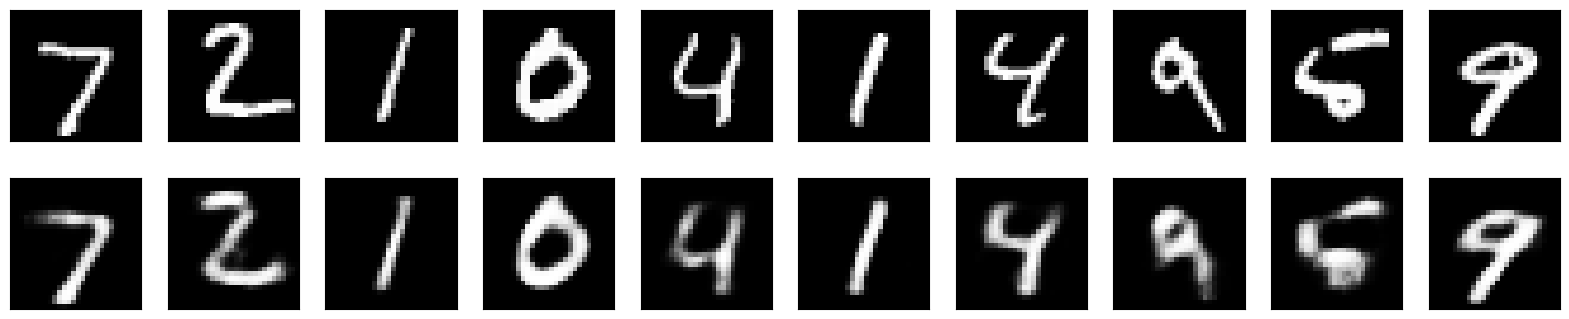

In [60]:
# @title Plotting deep autoencoder results
encoded = encoder.predict(x_test)
decoded = decoder.predict(encoded)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
# @title plotting for simple results
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

313/313 [==============================] - 3s 10ms/step


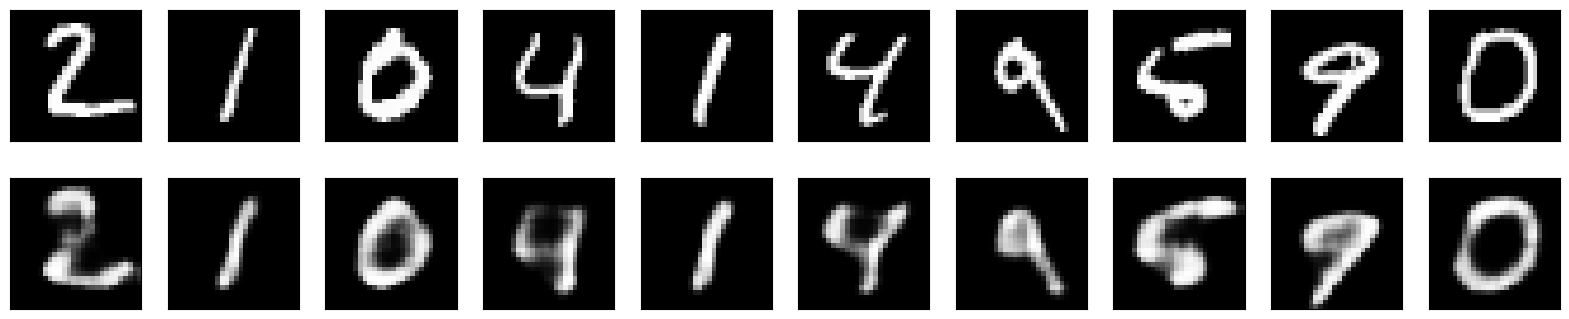

In [74]:
# @title plotting results for Conv autoencoder
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [70]:
# @title Tensorboard
!tensorboard --logdir=/tmp/autoencoder

2024-07-18 17:21:39.317109: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-18 17:21:39.317310: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-18 17:21:39.321894: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-18 17:21:40.939782: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to 